In [1]:
%load_ext autoreload
%autoreload 2


import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.pyplot import figure
sns.set(style="dark")
plt.style.use("ggplot")
sns.set()
rc('font', **{'family': 'Computer Modern', 'serif': ['Computer Modern'], 'size': 30})
rc('text', usetex=True)

from utils import *

/Users/mcurmei/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load case and contact data

In [2]:
case_df = load_case_data()
case_df.head()

,Case,Patient,Age,Gender,Nationality,Status,Infection Source,Country of Origin,Symptomatic ToConfirmation,Days ToRecover,Symptomatic At,Confirmed At,Recovered At,Displayed Symptoms?,SymptomaticToRecovery
0,6560,37 Year Old Male Bangladeshi,37.0,Male,Bangladeshi,In hospital,Local transmission,Unclear origin,NaN,NaN,NaT,2020-04-19,NaT,True,NaN
1,6558,37 Year Old Male Bangladeshi,37.0,Male,Bangladeshi,In hospital,Local transmission,Unclear origin,NaN,NaN,NaT,2020-04-19,NaT,True,NaN
2,6531,31 Year Old Male Bangladeshi,31.0,Male,Bangladeshi,In hospital,Local transmission,Unclear origin,NaN,NaN,NaT,2020-04-19,NaT,True,NaN
3,6529,43 Year Old Male Indian,43.0,Male,Indian,In hospital,Local transmission,Unclear origin,NaN,NaN,NaT,2020-04-19,NaT,True,NaN
4,6509,31 Year Old Male Myanmarian,31.0,Male,Myanmarian,In hospital,Local transmission,Unclear origin,NaN,NaN,NaT,2020-04-18,NaT,True,NaN


In [3]:
contact_df = load_contact_data()
contact_df.head()

,color,dashed,info,label,src,targ,isClusterTarg,isClusterSrc,isCluster,isHH
0,NaN,False,Tuas View Dormitory,NaN,Cluster 98,6560,False,True,True,False
1,NaN,False,Cochrane Lodge I,NaN,Cluster 82,6558,False,True,True,False
2,NaN,False,S11 Dormitory,NaN,Cluster 36,6531,False,True,True,False
3,NaN,False,S11 Dormitory,NaN,Cluster 36,6529,False,True,True,False
4,NaN,False,17 Sungei Kadut Street 4,NaN,Cluster 117,6509,False,True,True,False


In [4]:
for column in case_df.columns:
    print('# ---------------------------- {} ---------------------- #'.format(column))
    print(case_df[column].describe())

# ---------------------------- Case ---------------------- #
count     6588
unique    6588
top       5086
freq         1
Name: Case, dtype: object
# ---------------------------- Patient ---------------------- #
count                             6588
unique                             801
top       32 Year Old Male Bangladeshi
freq                               193
Name: Patient, dtype: object
# ---------------------------- Age ---------------------- #
count    6557.000000
mean       35.999237
std        11.652371
min         1.000000
25%        28.000000
50%        34.000000
75%        41.000000
max       102.000000
Name: Age, dtype: float64
# ---------------------------- Gender ---------------------- #
count     6588
unique       3
top       Male
freq      5807
Name: Gender, dtype: object
# ---------------------------- Nationality ---------------------- #
count            6588
unique             39
top       Bangladeshi
freq             2922
Name: Nationality, dtype: object
# --------

In [5]:
for column in contact_df.columns:
    print('# ---------------------------- {} ---------------------- #'.format(column))
    print(contact_df[column].describe())

# ---------------------------- color ---------------------- #
count        2840
unique          2
top       #FB7E81
freq         2263
Name: color, dtype: object
# ---------------------------- dashed ---------------------- #
count      4845
unique        2
top       False
freq       4250
Name: dashed, dtype: object
# ---------------------------- info ---------------------- #
count              4263
unique               76
top       S11 Dormitory
freq               1505
Name: info, dtype: object
# ---------------------------- label ---------------------- #
count         583
unique         22
top       Contact
freq          304
Name: label, dtype: object
# ---------------------------- src ---------------------- #
count           4845
unique          1009
top       Cluster 36
freq            1422
Name: src, dtype: object
# ---------------------------- targ ---------------------- #
count           4845
unique          3971
top       Cluster 36
freq              83
Name: targ, dtype: object


### Load infection graph

In [6]:
G_directed = get_infection_graph(clean=True, delta_days=5, case_df=case_df, contact_df=contact_df)

In [7]:
print_stats(G_directed)

The full graph has 4716 nodes, 4840 edges and 214 connected components
The largest connected component contains 2727 nodes
Out of the 4716 nodes 4640 are cases and 76 are clusters
There are 4167 cases connected to clusters and 49 of the connected components contain a cluster node
There are 219 household edges and 108 connected components contain household infections


### Compute $R_{eff}$ and $R_h$

In [8]:
def compute_R(cut_off, G_directed = G_directed, case_df = case_df, FNR=0.2):
    print("Cutoff date:{}".format(cut_off.strftime('%Y-%m-%d')))
    
    # get the source nodes
    sources = get_source_cases(G_directed, cut_off, case_df=case_df)
    connected_sources = sources['connected_sources']
    singleton_sources = sources['singleton_sources']
    n_connected_sources = len(connected_sources)
    n_singleton_sources = len(singleton_sources)
   
    # get the neighbors of the source nodes
    neighbor_nodes = get_neighbors(connected_sources,
                                   graph=G_directed, 
                                   keep_cluster=True,
                                   directed=True,
                                   n_type='all')
    
    # get the clusters among the neighbors
    cluster_nodes=[node for node in neighbor_nodes if is_cluster(node)]
    n_cluster_nodes = len(cluster_nodes)

    # for cluster nodes add all the infections that they created
    cluster_neighbor_nodes = get_neighbors(cluster_nodes, 
                                           graph=G_directed, 
                                           keep_cluster=False,
                                           directed=True,
                                           n_type='all')
        
    valid_nodes = merge_lists([connected_sources, neighbor_nodes, cluster_neighbor_nodes])
    n_valid_nodes = len(valid_nodes)
    
    ##   R_effective   ##
    G_relevant = G_directed.subgraph(valid_nodes)
    relevant_connected_components = list(nx.connected_component_subgraphs(G_relevant.to_undirected(reciprocal=False)))
    n_connected_components =  len(relevant_connected_components)    
    n_active_nodes = n_valid_nodes - n_cluster_nodes - n_connected_sources
    n_targets = n_active_nodes + n_connected_sources - n_connected_components
    
    print("Computing R:")     
    print('There are {} connected sources and {} singleton sources'.format(n_connected_sources,
                                                                          n_singleton_sources))
    print("There are {} valid nodes, they include sources, targets and relevant cluster nodes".format(n_valid_nodes)) 
    print("There are {} target nodes and {} target nodes".format(n_targets, n_connected_sources))
    R = n_targets/n_connected_sources
    R_low = n_targets/(n_connected_sources + n_singleton_sources)
    R_high = (n_targets + n_singleton_sources)/n_connected_sources
        
    print("Estimated R is {}/{} = {}. Range:({} - {}) ".format(n_targets, 
                                                               n_connected_sources, 
                                                               R,
                                                               R_low,
                                                               R_high))
    
    ##   R_household  ##  
    household_edges = get_household_edges(G_relevant)
    household_components = get_household_connected_components(G_relevant)
    n_households = len(household_components)
    individual_rh = merge_lists([get_individual_rh(cc, connected_sources) for cc in household_components], unique=False)
    rh_sd = compute_sd(individual_rh, n_connected_sources)
    all_household_members = merge_lists([cc.nodes() for cc in household_components])
    n_household_members = len(all_household_members)
    n_household_targets = n_household_members - n_households
 
    R_h = (n_household_targets/n_connected_sources)/(1-FNR)
    R_h_low = R_h - rh_sd/(1-FNR)
    R_h_high =  R_h + rh_sd/(1-FNR)
    print("There are {} secondary household cases, R_h = {}".format(n_household_targets, R_h))
    print("********************************************************************")
    results = dict(cut_off = cut_off,
                   n_connected_sources = n_connected_sources,
                   n_singleton_source = n_singleton_sources,
                   n_cluster_nodes = n_cluster_nodes,
                   n_targets = n_targets,
                   n_households = n_households,
                   n_household_targets = n_household_targets,
                   r_range = "{:.2f} ({:.2f}-{:.2f})".format(R, R_low, R_high),
                   r_h_range ="{:.2f} ({:.2f}-{:.2f})".format(R_h, R_h_low, R_h_high))
    return(results, (R, R_low, R_high, R_h, R_h_low, R_h_high, R_h/R))

### Iterate over cut-off dates

In [9]:
dti = pd.datetime(day=26, month = 1, year =2020)
dtf = pd.datetime(day=7, month = 4, year =2020)

date_range = pd.date_range(dti, dtf)
R_vals = [compute_R(cut_off, G_directed)[1] for cut_off in date_range]

Cutoff date:2020-01-26
Computing R:
There are 4 connected sources and 0 singleton sources
There are 18 valid nodes, they include sources, targets and relevant cluster nodes
There are 16 target nodes and 4 target nodes
Estimated R is 16/4 = 4.0. Range:(4.0 - 4.0) 
There are 3 secondary household cases, R_h = 0.9375
********************************************************************
Cutoff date:2020-01-27
Computing R:
There are 7 connected sources and 0 singleton sources
There are 18 valid nodes, they include sources, targets and relevant cluster nodes
There are 16 target nodes and 7 target nodes
Estimated R is 16/7 = 2.2857142857142856. Range:(2.2857142857142856 - 2.2857142857142856) 
There are 3 secondary household cases, R_h = 0.5357142857142857
********************************************************************
Cutoff date:2020-01-28
Computing R:
There are 8 connected sources and 0 singleton sources
There are 25 valid nodes, they include sources, targets and relevant cluster nodes


/Users/mcurmei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
/Users/mcurmei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


There are 11 secondary household cases, R_h = 0.31976744186046513
********************************************************************
Cutoff date:2020-02-12
Computing R:
There are 47 connected sources and 6 singleton sources
There are 82 valid nodes, they include sources, targets and relevant cluster nodes
There are 67 target nodes and 47 target nodes
Estimated R is 67/47 = 1.425531914893617. Range:(1.2641509433962264 - 1.553191489361702) 
There are 13 secondary household cases, R_h = 0.3457446808510638
********************************************************************
Cutoff date:2020-02-13
Computing R:
There are 56 connected sources and 6 singleton sources
There are 84 valid nodes, they include sources, targets and relevant cluster nodes
There are 68 target nodes and 56 target nodes
Estimated R is 68/56 = 1.2142857142857142. Range:(1.096774193548387 - 1.3214285714285714) 
There are 13 secondary household cases, R_h = 0.2901785714285714
*********************************************

There are 24 secondary household cases, R_h = 0.2941176470588235
********************************************************************
Cutoff date:2020-03-05
Computing R:
There are 110 connected sources and 14 singleton sources
There are 158 valid nodes, they include sources, targets and relevant cluster nodes
There are 134 target nodes and 110 target nodes
Estimated R is 134/110 = 1.2181818181818183. Range:(1.0806451612903225 - 1.3454545454545455) 
There are 24 secondary household cases, R_h = 0.2727272727272727
********************************************************************
Cutoff date:2020-03-06
Computing R:
There are 121 connected sources and 17 singleton sources
There are 161 valid nodes, they include sources, targets and relevant cluster nodes
There are 136 target nodes and 121 target nodes
Estimated R is 136/121 = 1.1239669421487604. Range:(0.9855072463768116 - 1.2644628099173554) 
There are 25 secondary household cases, R_h = 0.25826446280991733
****************************

There are 86 secondary household cases, R_h = 0.3180473372781065
********************************************************************
Cutoff date:2020-03-25
Computing R:
There are 368 connected sources and 292 singleton sources
There are 696 valid nodes, they include sources, targets and relevant cluster nodes
There are 572 target nodes and 368 target nodes
Estimated R is 572/368 = 1.5543478260869565. Range:(0.8666666666666667 - 2.347826086956522) 
There are 94 secondary household cases, R_h = 0.31929347826086957
********************************************************************
Cutoff date:2020-03-26
Computing R:
There are 395 connected sources and 319 singleton sources
There are 713 valid nodes, they include sources, targets and relevant cluster nodes
There are 585 target nodes and 395 target nodes
Estimated R is 585/395 = 1.481012658227848. Range:(0.819327731092437 - 2.288607594936709) 
There are 102 secondary household cases, R_h = 0.3227848101265822
*****************************

### Plot $R_{eff}$ and $R_h$

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

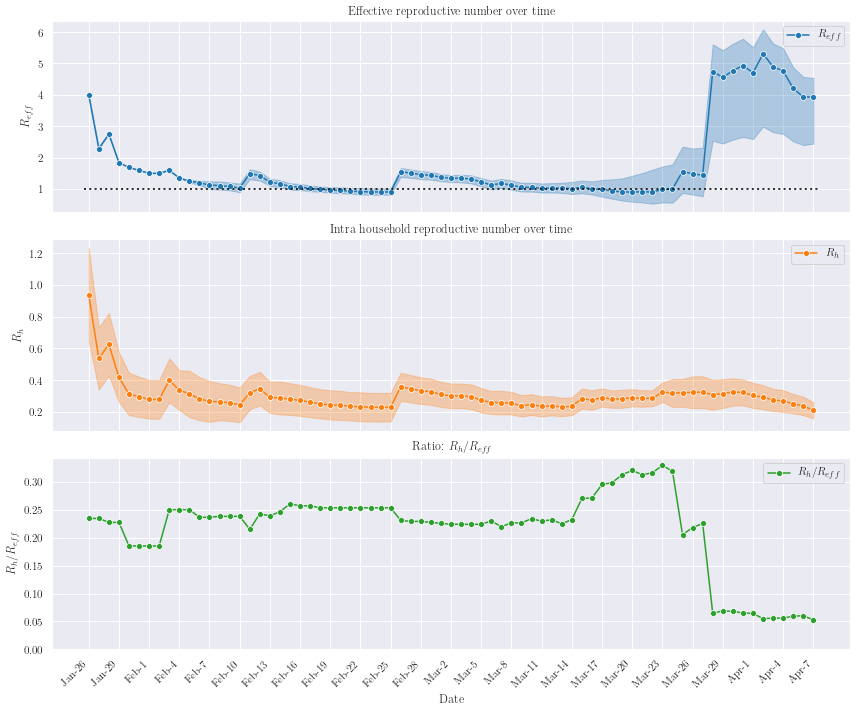

In [10]:
R_df = pd.DataFrame(R_vals, columns=['R', 'R_low', 'R_high','R_h', 'R_h_low','R_h_high', 'ratio'])
R_df['date'] = date_range

fig = figure()
f, ax = plt.subplots(3, sharex=True, figsize=(12,10))
p1=sns.lineplot(x='date', y='R', data=R_df, 
                marker='o', label ="$R_{eff}$",  
                ax=ax[0], color=plt.cm.tab10(0))
p1.axhline(y=1, ls = ':', lw = 2,
           label="$R_{eff}$=1",
           xmin = 0.04, xmax = 0.96, 
           alpha=0.9, color = 'k')

p1.fill_between(R_df['date'], R_df['R_low'], R_df['R_high'],
                alpha = 0.3, color=plt.cm.tab10(0))
x_dates = R_df['date'].dt.strftime('%b-%-d')
p1.xaxis.set_ticks(R_df.date[0::3])
p1.set_xticklabels(labels=x_dates[0::3], rotation=45, ha='right')
p1.set(xlabel = "Date", ylabel = "$R_{eff}$")
p1.set_title("Effective reproductive number over time")

p2=sns.lineplot(x='date', y='R_h', data=R_df, 
                marker='o', label ="$R_{h}$",  
                ax=ax[1], color=plt.cm.tab10(1))
p2.fill_between(R_df['date'], R_df['R_h_low'], R_df['R_h_high'], 
                alpha = 0.3, color=plt.cm.tab10(1))
p2.xaxis.set_ticks(R_df.date[0::3])
p2.set_xticklabels(labels=x_dates[0::3], rotation=45, ha='right')
p2.set(xlabel = "Date", ylabel = "$R_{h}$")
p2.set_title("Intra household reproductive number over time")

p3=sns.lineplot(x='date', y='ratio', data=R_df,
                marker='o', label ="${R_{h}}/{R_{eff}}$",  
                ax=ax[2], color=plt.cm.tab10(2))
p3.xaxis.set_ticks(R_df.date[0::3])
p3.set_xticklabels(labels=x_dates[0::3], rotation=45, ha='right')
p3.set(xlabel = "Date", ylabel = "${R_{h}}/{R_{eff}}$")
p3.set_title("Ratio: ${R_{h}}/{R_{eff}}$")
plt.ylim(0, None)
plt.tight_layout()
plt.show()
f.savefig('R_singapore_big.pdf', format='pdf')